In [1]:
%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [ ]:
import datetime
import numpy as np
import pandas as pd
import shap
import torch
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MAE, MSE

/Users/marcopeix/dev/neuralforecast/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-16 11:36:36,556	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-16 11:36:36,647	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
DATA_URL = "https://raw.githubusercontent.com/marcopeix/time-series-analysis/refs/heads/master/data/medium_views_published_holidays.csv"

df = pd.read_csv(DATA_URL, parse_dates=["ds"])
df.head()

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0


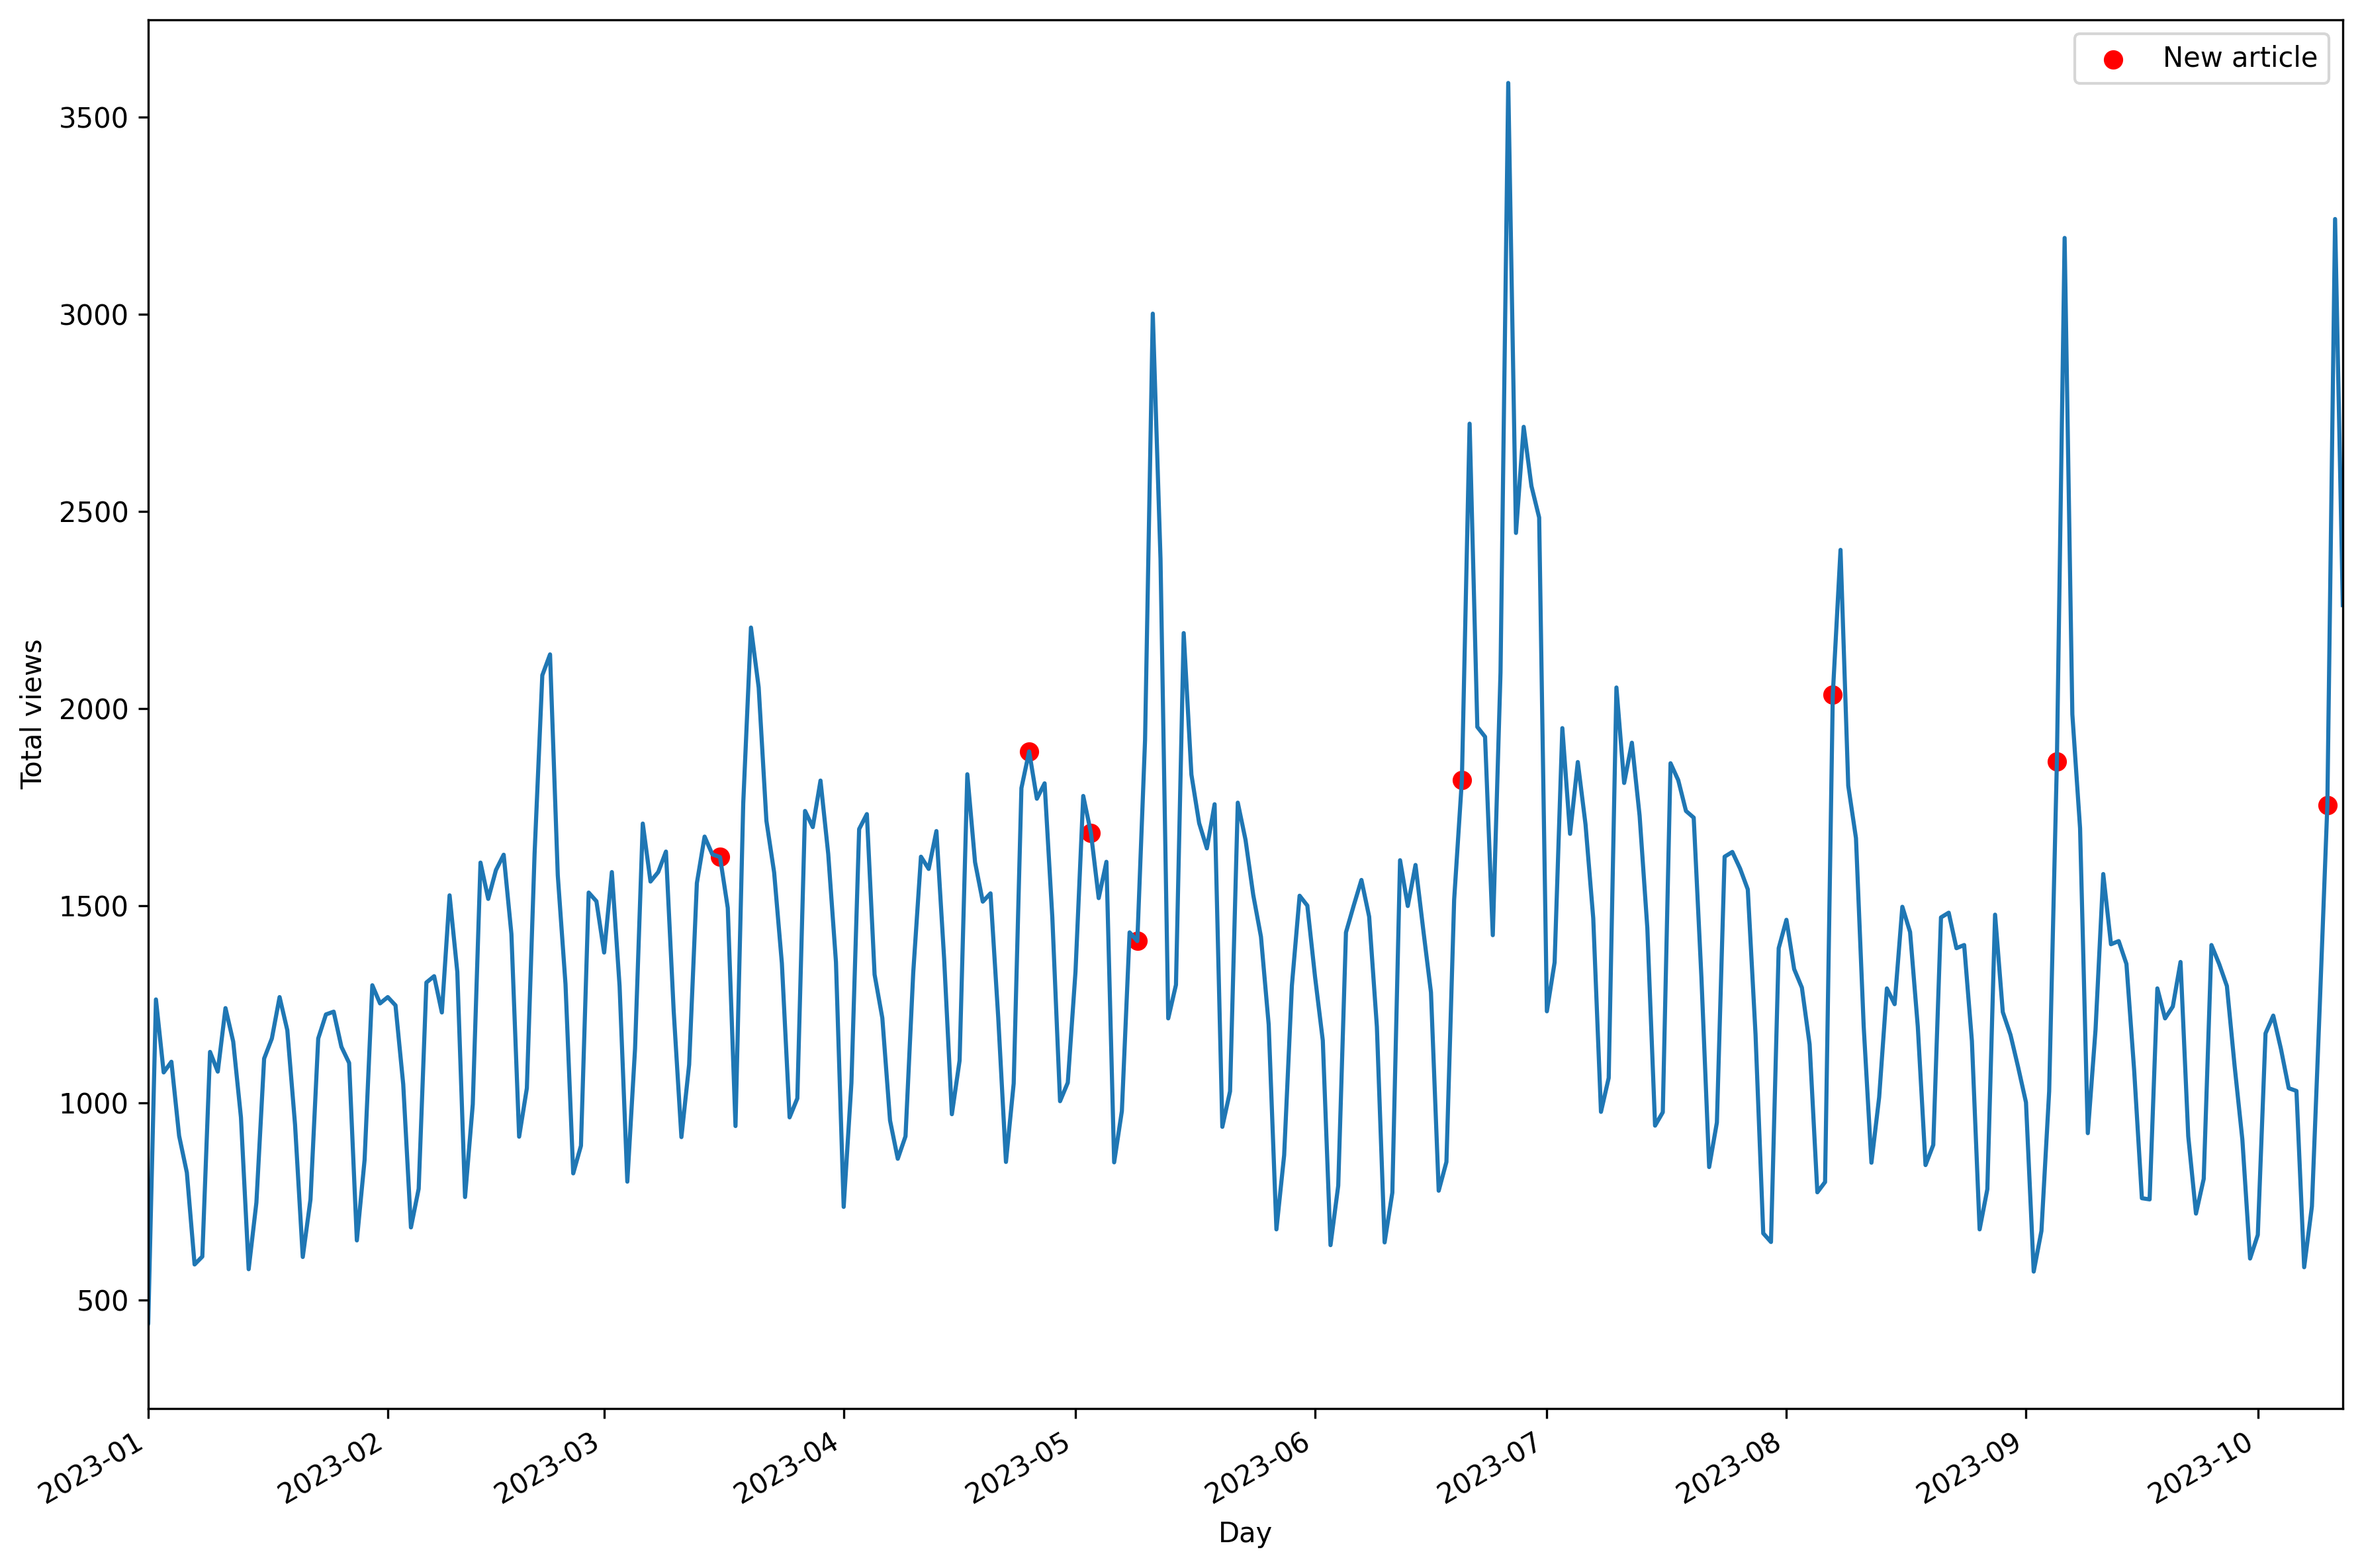

In [4]:
published_dates = df[df['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8), dpi=300)

ax.plot(df['ds'], df['y'])
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')
ax.set_xlim([datetime.date(2023, 1, 1), datetime.date(2023, 10, 12)])

fig.autofmt_xdate()


plt.tight_layout()

In [5]:
# Set random seeds for reproducibility
np.random.seed(42);
torch.manual_seed(42);

In [6]:
test = df.tail(28)
train = df.drop(test.index)

In [7]:
models = [
    NHITS(
        h=28,
        input_size=56,
        futr_exog_list=["published", "is_holiday"],
        max_steps=1000,
        loss=MSE(),
        valid_loss=MAE(),
        early_stop_patience_steps=3,
        scaler_type="robust",
        accelerator="cpu",
    ),
]

nf = NeuralForecast(
    models=models, 
    freq="D", 
)

nf.fit(df=train, val_size=28)

Seed set to 1
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | valid_loss   | MAE           | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.825    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Epoch 699: 100%|██████████| 1/1 [00:00<00:00, 28.12it/s, v_num=29617, train_loss_step=0.000271, train_loss_epoch=0.000271, valid_loss=937.0]


In [8]:
futr_df = test.drop(columns=["y"])

fcsts_df, explanations = nf.explain(
    futr_df=futr_df, 
    explainer="IntegratedGradients"
)

/Users/marcopeix/dev/neuralforecast/neuralforecast/core.py:1022: UserWarning: This function is beta and subject to change.
  warnings.warn("This function is beta and subject to change.")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using stored dataset.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


In [10]:
print(explanations["NHITS"]["insample"].shape)
print(explanations["NHITS"]["futr_exog"].shape)

torch.Size([1, 28, 1, 1, 56, 2])
torch.Size([1, 28, 1, 1, 84, 2])


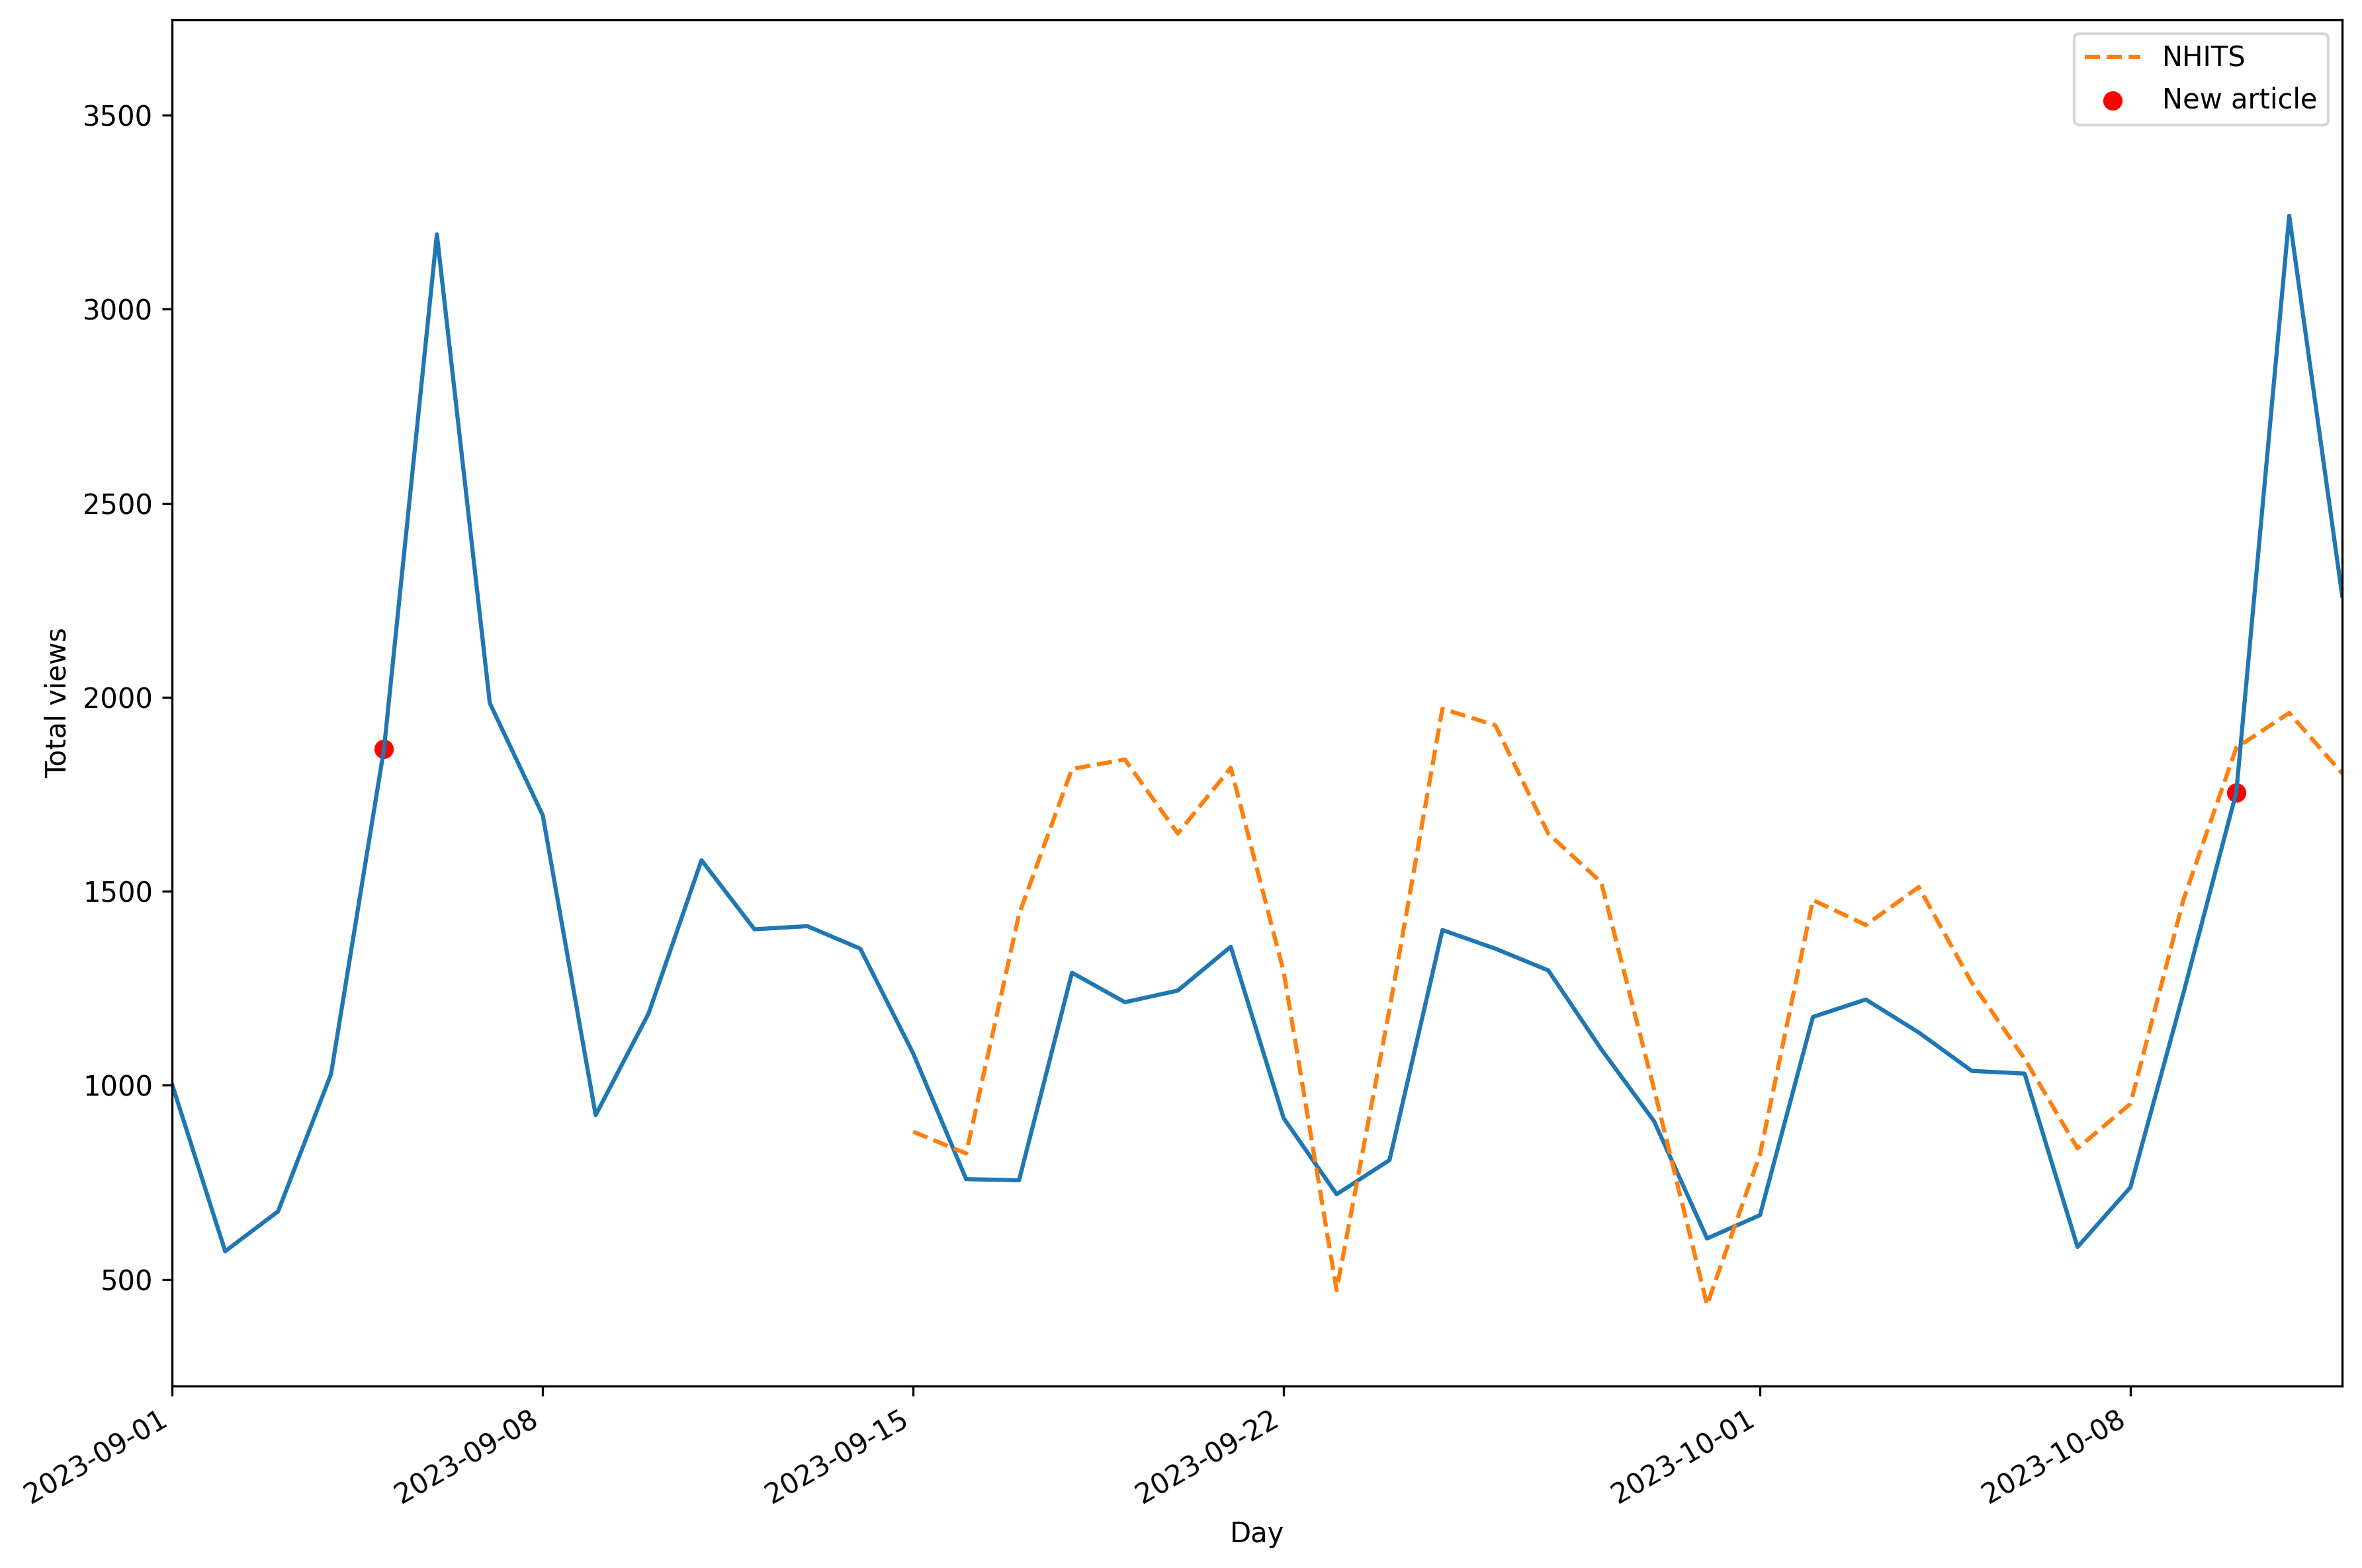

In [13]:
published_dates = df[df['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8), dpi=300)

ax.plot(df['ds'], df['y'])
ax.plot(fcsts_df["ds"], fcsts_df["NHITS"], ls="--", label="NHITS")
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')
ax.set_xlim([datetime.date(2023, 9, 1), datetime.date(2023, 10, 12)])

fig.autofmt_xdate()


plt.tight_layout()

In [16]:
holiday_idx = 24
published_idx = 25

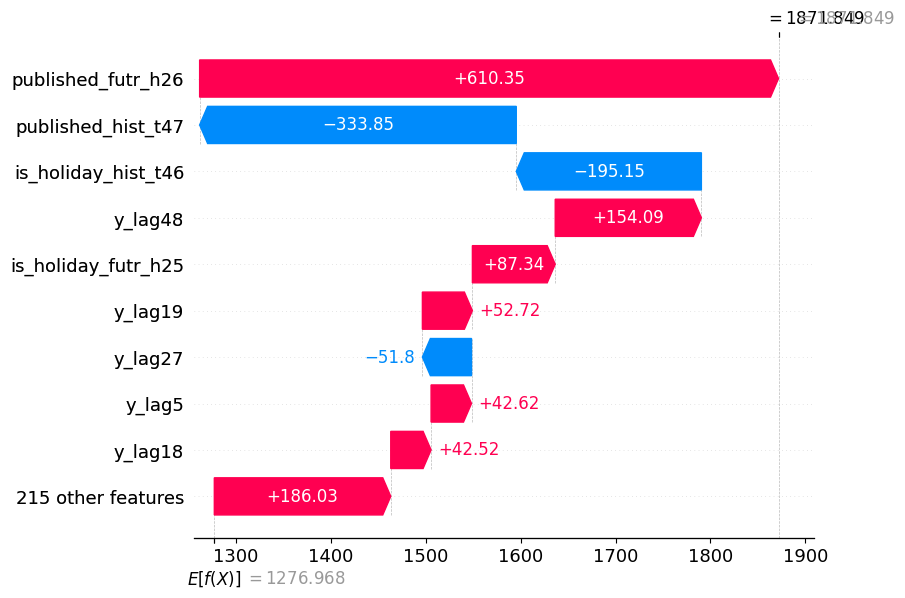

In [17]:
batch_idx = 0
horizon_idx = published_idx
output_idx = 0

attributions = []
feature_names = []

# Insample attributions
y_attr = explanations["NHITS"]["insample"][batch_idx, horizon_idx, 0, output_idx, :, 0]
mask_attr = explanations["NHITS"]["insample"][batch_idx, horizon_idx, 0, output_idx, :, 1]
combined_insample = (y_attr + mask_attr).cpu().numpy()
for i, attr in enumerate(combined_insample):
    attributions.append(attr)
    feature_names.append(f"y_lag{i+1}")

# futr_exog attributions
futr_attr = explanations["NHITS"]["futr_exog"][batch_idx, horizon_idx, 0, output_idx]
futr_attr = futr_attr.cpu().numpy()

# Process both future exogenous features
feature_labels = ["published", "is_holiday"]

for feat_idx in range(futr_attr.shape[1]):
    for t in range(futr_attr.shape[0]):
        attributions.append(futr_attr[t, feat_idx])
        if t < 56:  # Historical values (input_size part)
            feature_names.append(f"{feature_labels[feat_idx]}_hist_t{t+1}")
        else:  # Future values (horizon part)
            feature_names.append(f"{feature_labels[feat_idx]}_futr_h{t-55}")

shap_values = np.array(attributions)

# baseline_predictions
baseline = float(explanations["NHITS"]["baseline_predictions"][batch_idx, horizon_idx, 0, output_idx].cpu())

# Create SHAP Explanation
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=baseline,
    feature_names=feature_names
)

shap.plots.waterfall(shap_explanation)

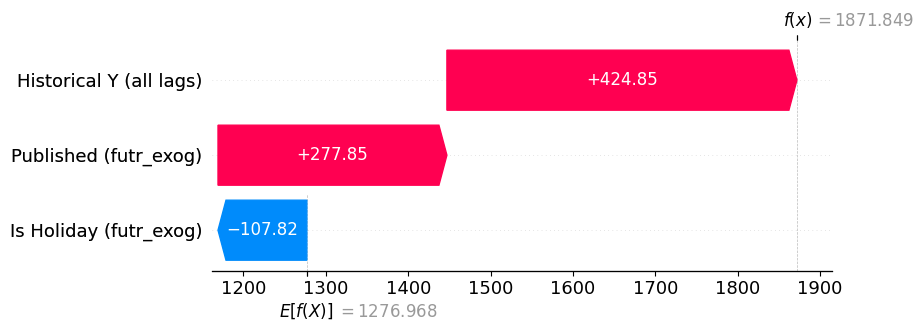

In [20]:
batch_idx = 0
horizon_idx = published_idx
output_idx = 0

baseline = float(explanations["NHITS"]["baseline_predictions"][batch_idx, horizon_idx, output_idx, output_idx].cpu())
insample_sum = float(explanations["NHITS"]["insample"][batch_idx, horizon_idx, output_idx, output_idx, :, :].sum().cpu())

# Separate sums for each future exogenous feature
published_sum = float(explanations["NHITS"]["futr_exog"][batch_idx, horizon_idx, output_idx, output_idx, :, 0].sum().cpu())
is_holiday_sum = float(explanations["NHITS"]["futr_exog"][batch_idx, horizon_idx, output_idx, output_idx, :, 1].sum().cpu())

feature_names = []
shap_values = []

if insample_sum != 0:
    feature_names.append("Historical Y (all lags)")
    shap_values.append(insample_sum)

if published_sum != 0:
    feature_names.append("Published (futr_exog)")
    shap_values.append(published_sum)

if is_holiday_sum != 0:
    feature_names.append("Is Holiday (futr_exog)")
    shap_values.append(is_holiday_sum)

shap_values = np.array(shap_values)

# Create SHAP Explanation
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=baseline,
    feature_names=feature_names
)

shap.plots.waterfall(shap_explanation)

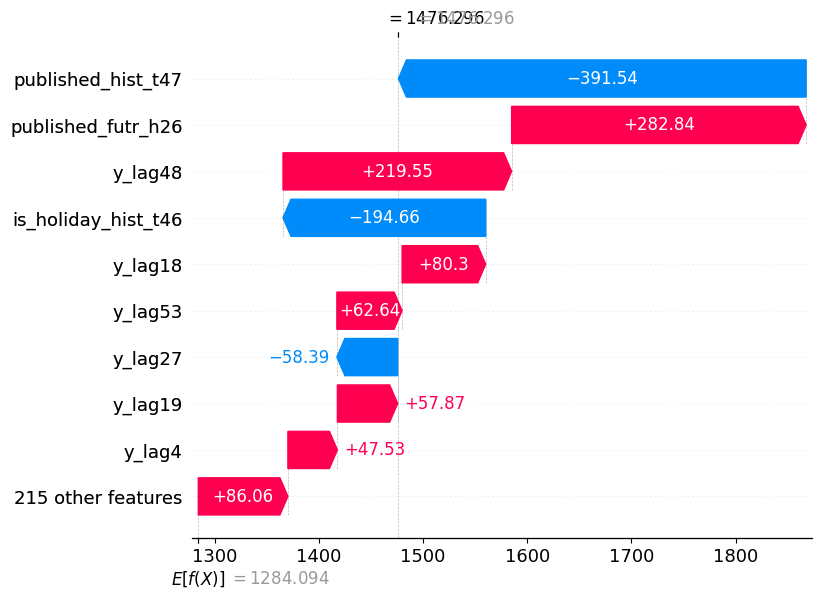

In [19]:
batch_idx = 0
horizon_idx = holiday_idx
output_idx = 0

attributions = []
feature_names = []

# Insample attributions
y_attr = explanations["NHITS"]["insample"][batch_idx, horizon_idx, 0, output_idx, :, 0]
mask_attr = explanations["NHITS"]["insample"][batch_idx, horizon_idx, 0, output_idx, :, 1]
combined_insample = (y_attr + mask_attr).cpu().numpy()
for i, attr in enumerate(combined_insample):
    attributions.append(attr)
    feature_names.append(f"y_lag{i+1}")

# futr_exog attributions
futr_attr = explanations["NHITS"]["futr_exog"][batch_idx, horizon_idx, 0, output_idx]
futr_attr = futr_attr.cpu().numpy()

# Process both future exogenous features
feature_labels = ["published", "is_holiday"]

for feat_idx in range(futr_attr.shape[1]):
    for t in range(futr_attr.shape[0]):
        attributions.append(futr_attr[t, feat_idx])
        if t < 56:  # Historical values (input_size part)
            feature_names.append(f"{feature_labels[feat_idx]}_hist_t{t+1}")
        else:  # Future values (horizon part)
            feature_names.append(f"{feature_labels[feat_idx]}_futr_h{t-55}")

shap_values = np.array(attributions)

# baseline_predictions
baseline = float(explanations["NHITS"]["baseline_predictions"][batch_idx, horizon_idx, 0, output_idx].cpu())

# Create SHAP Explanation
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=baseline,
    feature_names=feature_names
)

shap.plots.waterfall(shap_explanation)

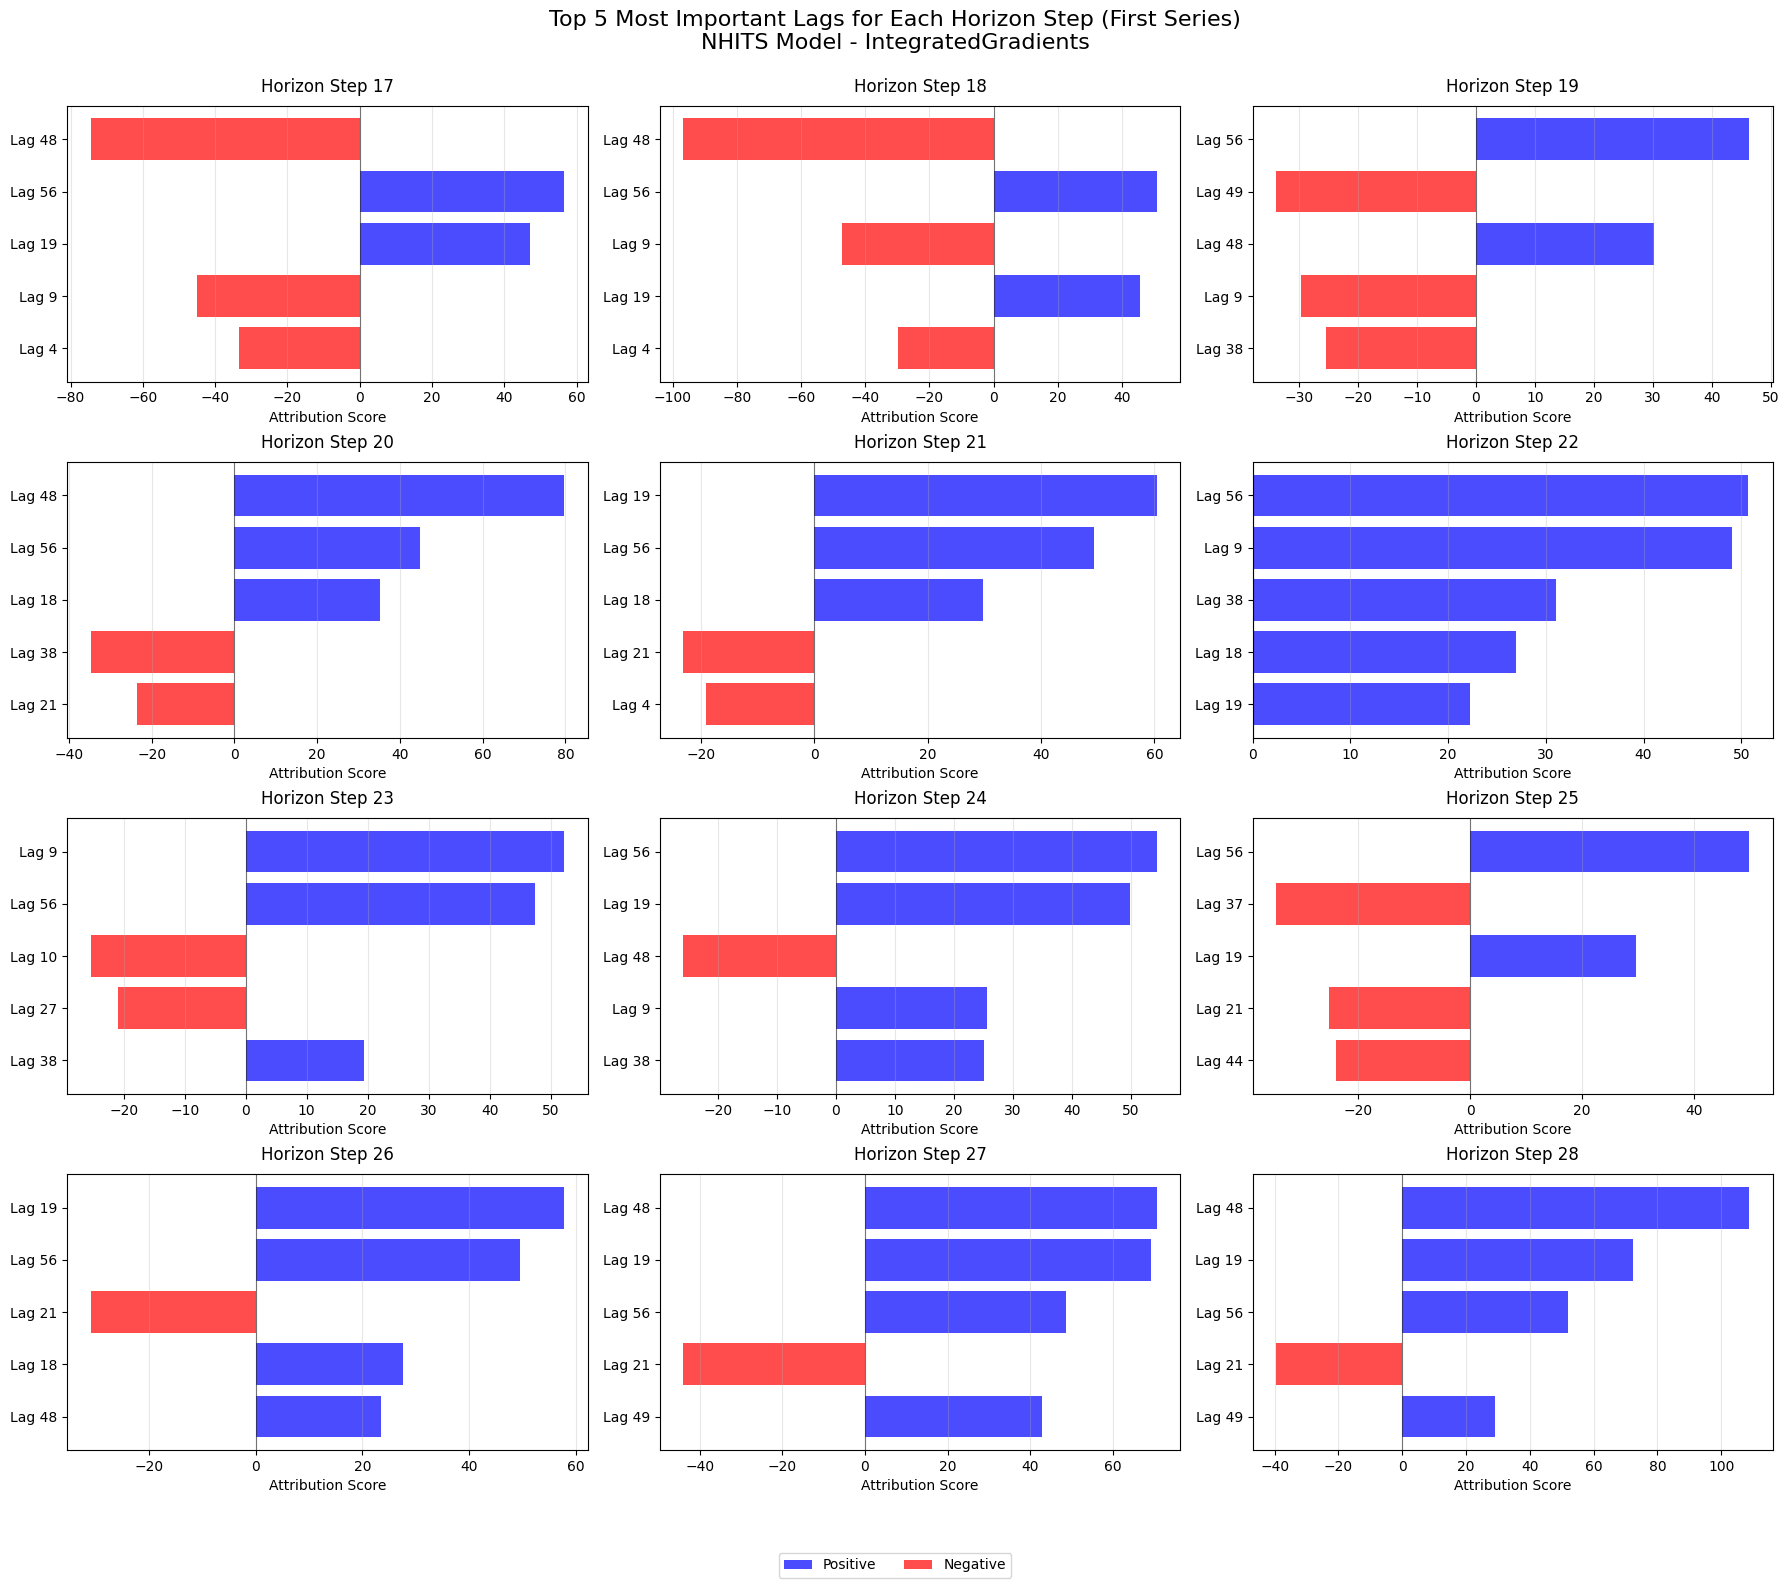

In [ ]:
data = explanations["NHITS"]["insample"][0, :-12, 0, 0, :, 0]  # Shape: [12, 56]

# Create 4x3 subplot grid
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for h in range(12):
    horizon_attrs = data[h, :].cpu().numpy()
    
    # Get top 5 lags by absolute value
    top5_indices = np.argsort(np.abs(horizon_attrs))[-5:]
    top5_values = horizon_attrs[top5_indices]
    top5_lags = top5_indices + 1
    
    # Sort by absolute value (most important at top)
    sort_order = np.argsort(np.abs(top5_values))
    
    # Create horizontal bar plot
    colors = ['red' if v < 0 else 'blue' for v in top5_values[sort_order]]
    axes[h].barh(range(5), top5_values[sort_order], color=colors, alpha=0.7)
    axes[h].set_yticks(range(5))
    axes[h].set_yticklabels([f'Lag {lag}' for lag in top5_lags[sort_order]])
    axes[h].set_title(f'Horizon Step {h+17}', fontsize=12, pad=10)
    axes[h].axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
    axes[h].grid(axis='x', alpha=0.3)
    axes[h].set_xlabel('Attribution Score', fontsize=10)

plt.suptitle('Top 5 Most Important Lags for Each Horizon Step (First Series)\nNHITS Model - IntegratedGradients', 
             fontsize=16, y=0.98)

# Add legend
from matplotlib.patches import Patch
fig.legend(handles=[Patch(facecolor='blue', alpha=0.7, label='Positive'),
                    Patch(facecolor='red', alpha=0.7, label='Negative')],
          loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=2)

plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.08)
plt.show()